### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import datetime as dt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt 
plt.style.use('dark_background')

### Loading Data
Data source comes from **Fred API, Glassnode API, and Yfinance**

In [3]:
BTC_LEM2 = pd.read_csv('/Users/atlantropa/Desktop/USC/Blockchain Club/Liquidity/Fed/BTC_LEM2.csv')

In [4]:
BTC_LEM2.shape

(891, 35)

In [5]:
BTC_LEM2.head()

,Date,Open,High,Low,Close,Volume,Assets ($ Billion),TGA ($ Billion),RRP ($ Billion),Net Liquidity,...,USDT_30d ($ Million),USDT_90d ($ Million),USDC_1d ($ Million),USDC_7d ($ Million),USDC_30d ($ Million),USDC_90d ($ Million),Total Supply ($ Billion),Macro&Crypto Liquidity,PERP_OI_btc,PERP_FR_btc
0,2020-07-23,9527.141602,9610.247070,9483.003906,9581.072266,18146399002,6964.755,1804.944,0.0,5159.811,...,9187.991663,6361.032509,1112.861820,1101.684172,926.919889,734.284096,11.296681,5171.107681,20.9,0.00005
1,2020-07-24,9585.514648,9623.336914,9481.454102,9536.892578,16552768325,6964.755,1804.944,0.0,5159.811,...,9187.991663,6361.032509,1114.014303,1098.448596,926.919889,750.405209,11.282897,5171.093897,20.3,0.00002
2,2020-07-25,9539.485352,9704.556641,9530.211914,9677.113281,16610070933,6964.755,1804.944,0.0,5159.811,...,9187.991663,6361.032509,1105.896543,1102.128113,926.919889,751.318500,11.280737,5171.091737,21.2,0.00008
3,2020-07-26,9680.234375,10023.807617,9652.847656,9905.166992,20507998997,6964.755,1804.944,0.0,5159.811,...,9187.991663,6361.032509,1104.434260,1119.952382,926.919889,750.019696,11.307171,5171.118171,20.3,0.00026
4,2020-07-27,9905.217773,11298.221680,9903.969727,10990.873047,35359749590,6964.755,1804.944,0.0,5159.811,...,9187.991663,6361.032509,1132.450810,1118.855433,926.919889,745.794524,11.339053,5171.150053,20.7,0.00070


### Feature Engineering

In [6]:
#Conver to datetime
BTC_LEM2['Date'] = pd.to_datetime(BTC_LEM2['Date'])

#Extract Year Month and Day
BTC_LEM2['Year'] = BTC_LEM2['Date'].dt.year
BTC_LEM2['Month'] = BTC_LEM2['Date'].dt.month
BTC_LEM2['Day'] = BTC_LEM2['Date'].dt.day

In [7]:
# Selecting Features -- Extract the "Close" Feature
X = BTC_LEM2.iloc[:, [1,2,3] + list(range(5, BTC_LEM2.shape[1]))]
#X = BTC_LEM2.iloc[:, list(range(5, BTC_LEM2.shape[1]))]
column_names = X.columns

### Lagging X & y 
In this case, I've created a **1-day, 1-week, and 2-week** lag for X.

In [8]:
# Creating time lags in X features
X_1d = X.drop(X.index[0])
print(X_1d.shape)

X_7d = X.drop(X.index[0:7])
print(X_7d.shape)

X_14d = X.drop(X.index[0:14])
print(X_14d.shape)

(890, 36)
(884, 36)
(877, 36)


In [9]:
# Match the time lag of X with y
y_1d = BTC_LEM2['Close'].shift(-1).dropna(inplace=False)
print(y_1d.shape)

y_7d = BTC_LEM2['Close'].shift(-7).dropna(inplace=False)
print(y_7d.shape)

y_14d = BTC_LEM2['Close'].shift(-14).dropna(inplace=False)
print(y_14d.shape)

(890,)
(884,)
(877,)


### Scaling X

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
#Scaling my X features
def scale_my_X(df):
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler to the features
    scaler.fit(df)

    # Scale the features
    return scaler.transform(df)


In [12]:
#After each X got scaled, attach them with column names 
Scaled_X_1d = scale_my_X(X_1d)
Scaled_X_1d = pd.DataFrame(Scaled_X_1d, columns=column_names)

Scaled_X_7d = scale_my_X(X_7d)
Scaled_X_7d = pd.DataFrame(Scaled_X_7d, columns=column_names)

Scaled_X_14d = scale_my_X(X_14d)
Scaled_X_14d = pd.DataFrame(Scaled_X_14d, columns=column_names)

### Splitting Data for training and testing

In [13]:
# Setting up Params
seed = 42
test_size = 0.2

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Scaled_X_14d, y_14d, test_size=test_size, random_state=seed, shuffle=False)


# 1. XG Boost Model

In [14]:
# Initialize variables to store scores
scores = []
mse = []
mae = []

# Walk-forward validation
# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Scaled_X_7d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Scaled_X_7d.iloc[test_index], y_7d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Scaled_X_7d))).difference(test_index))
    X_train, y_train = Scaled_X_7d.iloc[train_index], y_7d.iloc[train_index]
    # Initialize the model
    model = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 50)
    # fit the model 
    model.fit(X_train, y_train)
    # Calculate accuracy score
    accuracy_score = model.score(X_test, y_test)
    scores.append(accuracy_score)
    # Make predictions
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))

### 1.1 Feature Selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

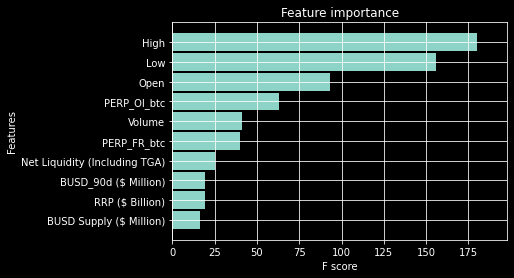

In [15]:
# To see the top 10 features from my X

importances = model.get_booster().get_fscore()
importance_df = pd.DataFrame({
    'feature': list(importances.keys()),
    'importance': list(importances.values())
}).sort_values('importance', ascending=False)

top_10_features = importance_df.head(20)
xgb.plot_importance(model, height = 0.9, importance_type = 'weight', show_values = False, grid=True, max_num_features=10)


### 1.2 XGBoost After Dimension Reduction
Decided to use **F score of 25** as the cutoff for important features since features below 25 have similar f-scores.

In [16]:
Fil_Scaled_X_14d = Scaled_X_14d[['Open', 'High', 'Low', 'Volume', 'PERP_OI_btc', 'PERP_FR_btc', 'Net Liquidity (Including TGA)']]

seed = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(Fil_Scaled_X_14d, y_14d, test_size=test_size, random_state=seed, shuffle=False)


In [17]:
# Initialize variables to store scores
scores = []
mse = []
mae = []

#Walk-forward Validation
# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    # Initialize the model
    model = XGBRegressor(learning_rate = 0.1, max_depth = 9, n_estimators = 50)
    # fit the model 
    model.fit(X_train, y_train)
    # Calculate accuracy score
    accuracy_score = model.score(X_test, y_test)
    scores.append(accuracy_score)
    # Make predictions
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))

### 1.3 Tuning Hyperparams
Best parameters:
- learning_rate: 0.1
- max_depth: 9
- n_estimators': 50

In [18]:
# Fine-tune Hyperparams
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50}


### 1.4 XGBoost Model Evaluation 

In [19]:
print("Mean accuracy score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))

Mean accuracy score:  0.9556811086409931
Mean MSE:  1500603.5832336713
Mean MAE:  881.480425853191


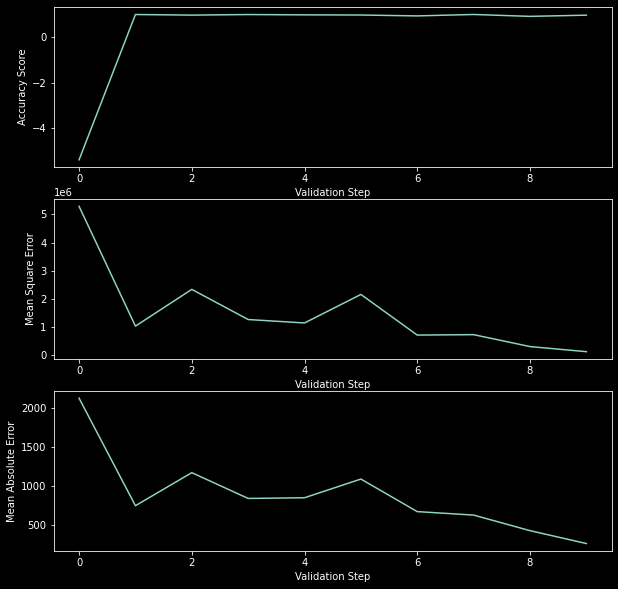

In [20]:
#Performance of Each Validation Step Along the Way

fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')

plt.savefig("XGB_Accu_MSE_MAE.jpg")
plt.show()

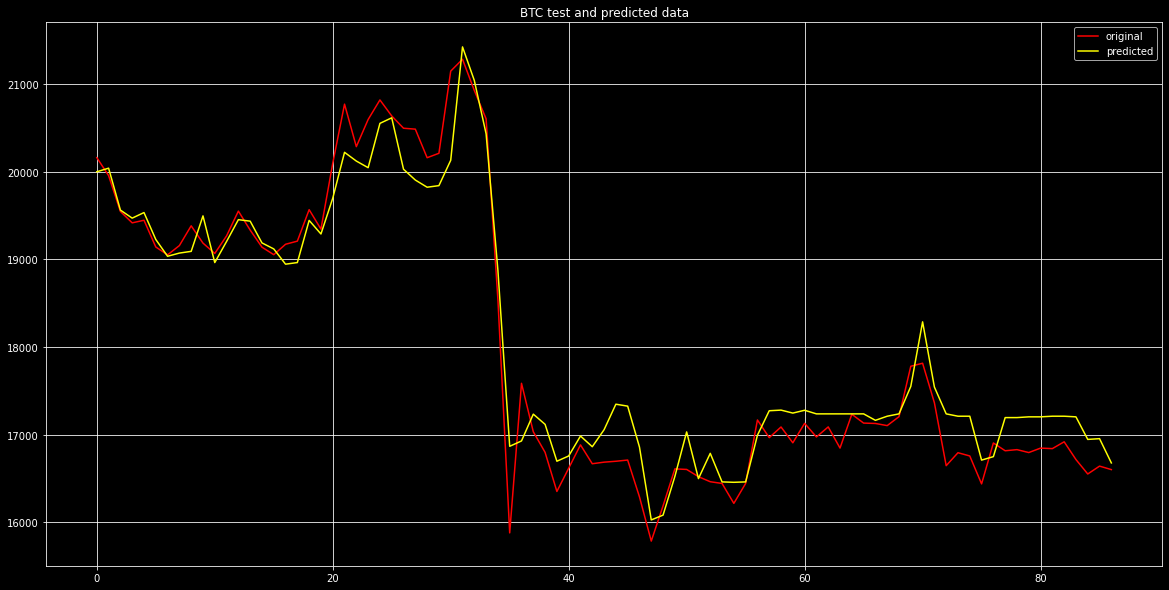

In [21]:
# Visualization of Predicted vs Test 
x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.savefig("XGB_test_v_pred.jpg")
plt.show()

# 2. Random Forest Model

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
# Initialize variables to store scores
scores = []
mse = []
mae = []
mape = []

# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    # Initialize the model
    model = RandomForestRegressor(max_depth = 7, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 50)
    # fit the model 
    model.fit(X_train, y_train)
    # Calculate accuracy score
    accuracy_score = model.score(X_test, y_test)
    scores.append(accuracy_score)
    # Make predictions
    y_pred = model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    mape.append((np.abs((y_test - y_pred) / y_test)) * 100)

### 2.1 Tuning Hyperparams 
Best parameters:
- max_depth: 7
- min_samples_leaf: 2
- min_samples_split: 3
- n_estimators: 50

In [32]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the model
rf = RandomForestRegressor()

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50}


### 2.2 Random Forest Model Evaluation

In [24]:
#Evaluation Metrics
print("Mean accuracy score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))

Mean accuracy score:  0.9255769980869082
Mean MSE:  1672125.068893154
Mean MAE:  923.5079158069623


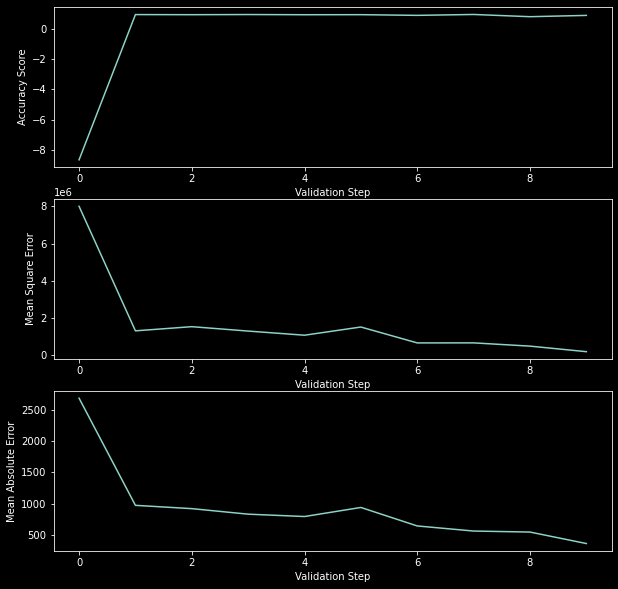

In [25]:
#Performance of Each Validation Step Along the Way

fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')

plt.savefig("RF_Accu_MSE_MAE.jpg")
plt.show()

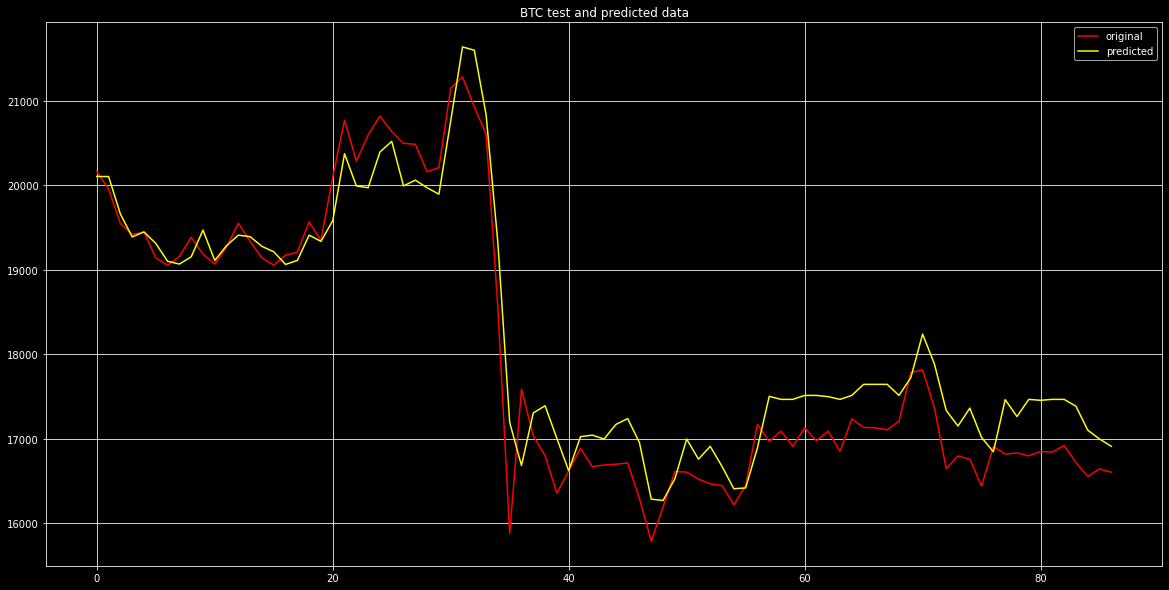

In [26]:
# Visualization of Predicted vs Test
y_pred = model.predict(X_test)

x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.savefig("RF_test_v_pred.jpg")
plt.show()

# 3. Decision Tree Model
Best Parameters
- max_depth: 7
- min_samples_leaf: 1
- min_samples_split: 4
- random_state: 42

In [52]:
# Import the necessary libraries
from sklearn.tree import DecisionTreeRegressor

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'random_state': [seed]
}

# Create the decision tree model
dt_model = DecisionTreeRegressor()

# Create the grid search object
grid_search = GridSearchCV(dt_model, param_grid, cv=10, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("best parameter is: ", best_params)

# Create a new decision tree model with the best hyperparameters
dt_model = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                                  min_samples_leaf=best_params['min_samples_leaf'],
                                  min_samples_split=best_params['min_samples_split'],
                                  random_state=best_params['random_state'])

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Initialize variables to store scores
scores = []
mse = []
mae = []
mape = []

# Walk-forward
# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    # Make predictions on the test data
    y_pred = dt_model.predict(X_test)
    # Calculate accuracy score
    accuracy_score = dt_model.score(X_test, y_test)
    scores.append(accuracy_score)
    mse.append(mean_squared_error(y_test, y_pred))
    mae.append(mean_absolute_error(y_test, y_pred))
    mape.append((np.abs((y_test - y_pred) / y_test)) * 100)

best parameter is:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}


### 3.1 Decision Tree Model Evaluation

In [28]:
print("Last Accuracy Score: ", scores[-1])
print("Mean MSE: ", np.mean(mse))
print("Mean MAE: ", np.mean(mae))
print("Best Params: ", best_params)

Last Accuracy Score:  0.8486454900507138
Mean MSE:  255101.1029466535
Mean MAE:  336.96058241713104
Best Params:  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4, 'random_state': 42}


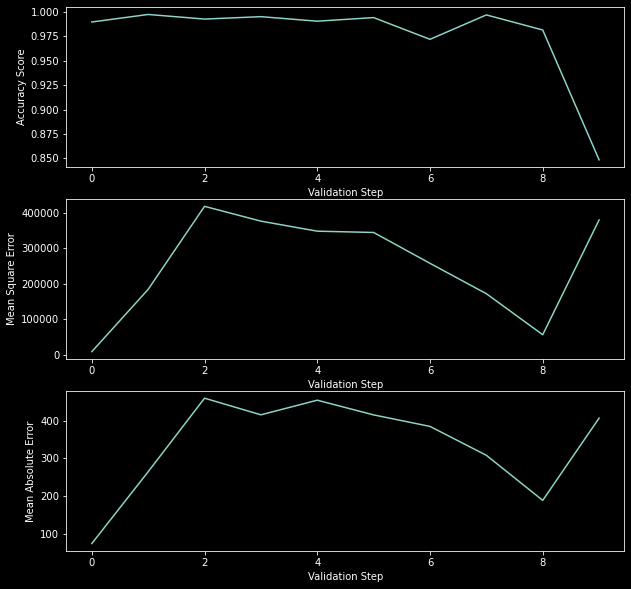

In [53]:
# Performance of Metrics along each steps

fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')

plt.savefig("DT_Accu_MSE_MAE.jpg")
plt.show()

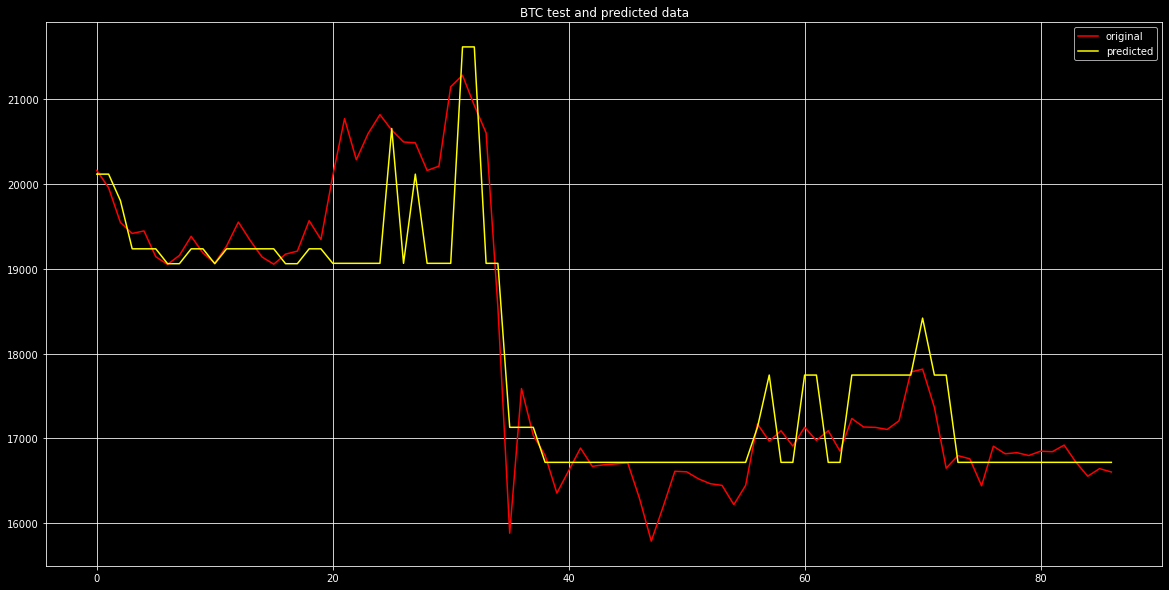

In [30]:
# Visualization of Original vs Predicted 
y_pred = dt_model.predict(X_test)

x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, y_pred, label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.savefig("DT_test_v_pred.jpg")
plt.show()

## 4. Stacking Ensemble Model

In [45]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Initialize the models
rf_model = RandomForestRegressor(max_depth = 7, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 50)
xgb_model = XGBRegressor(learning_rate = 0.1, max_depth = 9, n_estimators = 50)
dt_model = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 1, min_samples_split = 4, random_state = 42)

# Initialize variables to store scores
meta_predictions = []
scores = []
mse_values = []
mae_values = []

# Split the data into n_splits chunks
n_splits = 10
chunks = np.array_split(range(len(Fil_Scaled_X_14d)), n_splits)
for i in range(n_splits):
    # Get the test data
    test_index = chunks[i]
    X_test, y_test = Fil_Scaled_X_14d.iloc[test_index], y_14d.iloc[test_index]
    
    # Get the train data
    train_index = list(set(range(len(Fil_Scaled_X_14d))).difference(test_index))
    X_train, y_train = Fil_Scaled_X_14d.iloc[train_index], y_14d.iloc[train_index]
    
    # fit the model 
    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    dt_model.fit(X_train, y_train)
    
    # Make predictions
    rf_predictions = rf_model.predict(X_test)
    xgb_predictions = xgb_model.predict(X_test)
    dt_predictions = dt_model.predict(X_test)
    
    # Combine the predictions from the base models into a new dataset
    val_predictions = pd.DataFrame({
        "rf_predictions": rf_predictions,
        "xgb_predictions": xgb_predictions,
        "dt_predictions": dt_predictions
    })
    
    # Train a new meta model on the combined dataset of predictions
    meta_model = LinearRegression()
    meta_model.fit(val_predictions, y_test)

    # Use the meta model to make predictions on the validation set
    meta_predictions.append(meta_model.predict(val_predictions))
    
    # Append MSE and MAE to the lists
    accuracy_score = meta_model.score(val_predictions, y_test)
    scores.append(accuracy_score)
    mse_values.append(mean_squared_error(y_test, meta_model.predict(val_predictions)))
    mae_values.append(mean_absolute_error(y_test, meta_model.predict(val_predictions)))    

### 4.1 Stacking Ensemble Model Evaluation

In [46]:
print("accuracy score is: ", accuracy_score)
print("MSE is: ", np.mean(mse_values))
print("MAE is: ", np.mean(mae_values))

accuracy score is:  0.9707182199871385
MSE is:  765537.8088408795
MAE is:  635.3339334929526


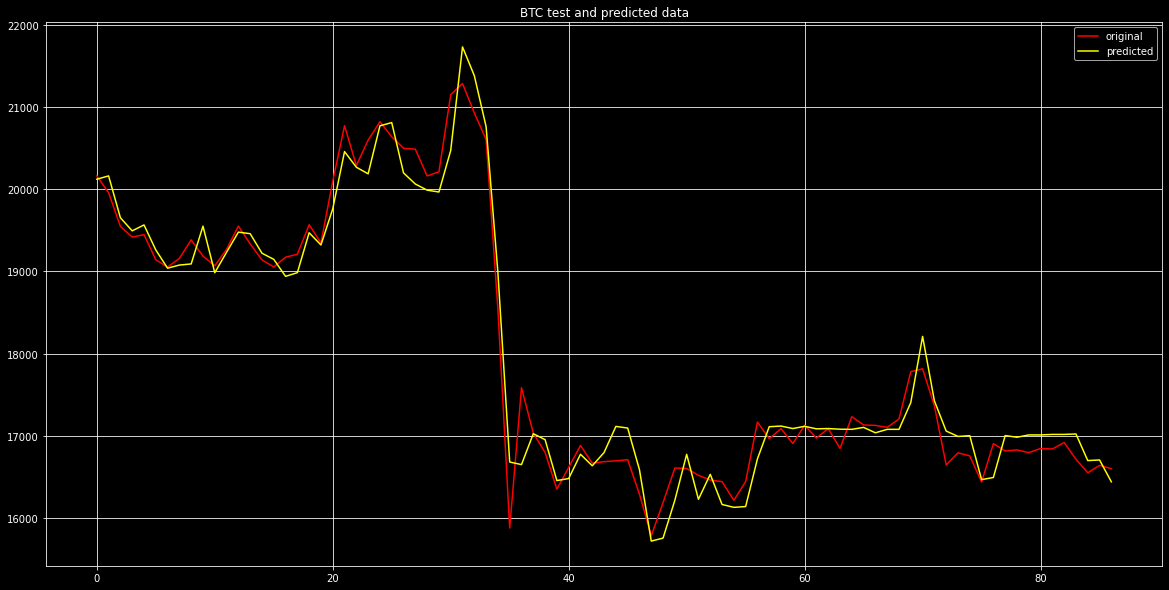

In [54]:
x_ax = range(len(y_test))
plt.subplots(figsize=(20, 10))
plt.plot(x_ax, y_test, label="original", color = 'red')
plt.plot(x_ax, meta_model.predict(val_predictions), label="predicted", color = 'yellow')
plt.title("BTC test and predicted data")
plt.grid()
plt.legend()
plt.savefig("Stacking_test_v_pred.jpg")
plt.show()

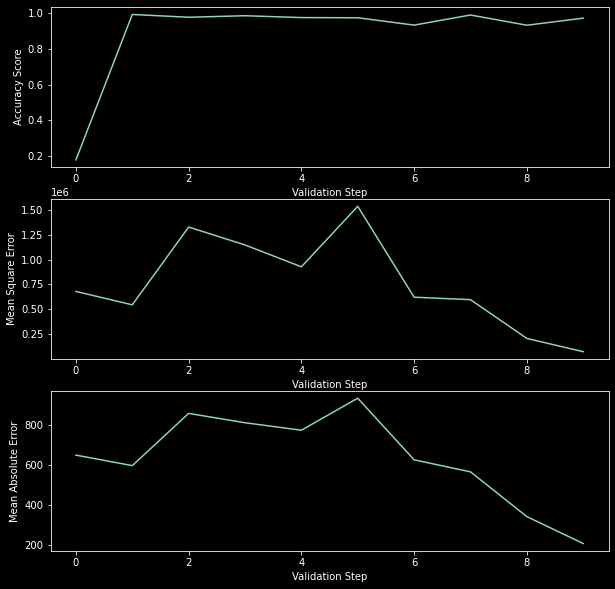

In [51]:
# Performance of Metrics along each steps

fig, ax = plt.subplots(figsize=(10, 10), nrows=3)

ax[0].plot(scores)
ax[0].set_xlabel('Validation Step')
ax[0].set_ylabel('Accuracy Score')

ax[1].plot(mse_values)
ax[1].set_xlabel('Validation Step')
ax[1].set_ylabel('Mean Square Error')

ax[2].plot(mae_values)
ax[2].set_xlabel('Validation Step')
ax[2].set_ylabel('Mean Absolute Error')

plt.savefig("Stacking_Accu_MSE_MAE.jpg")
plt.show()